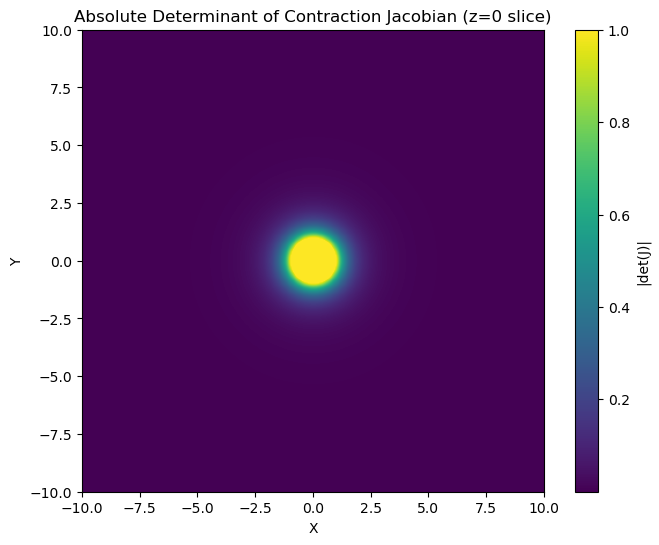

In [1]:
import torch
import matplotlib.pyplot as plt

def contract_points(x, eps=torch.finfo(torch.float32).eps, dim=-1):
    mag = torch.sqrt(
        torch.clip(torch.sum(x**2, dim=dim, keepdim=True), eps, None)
    )
    return torch.where(mag <= 1, x, (2 - (1 / mag)) * (x / mag))

def contraction_jacobian(means):
    jc_means = torch.vmap(torch.func.jacrev(contract_points))(means.view(-1, means.shape[-1]))
    jc_means = jc_means.view(list(means.shape) + [means.shape[-1]])
    return jc_means

num_points = 400  # adjust for finer/coarser grid
x_vals = torch.linspace(-10, 10, num_points)
y_vals = torch.linspace(-10, 10, num_points)

# Create a meshgrid. Using 'ij' indexing so that x_vals corresponds to rows.
X, Y = torch.meshgrid(x_vals, y_vals, indexing='ij')

# Fix z coordinate to 0 for the 2D slice
Z = torch.zeros_like(X)

# Combine into a (N, 3) tensor where N = num_points*num_points
points = torch.stack([X.flatten(), Y.flatten(), Z.flatten()], dim=-1)

# Compute the Jacobian at each point and take the absolute determinant
J = contraction_jacobian(points).float()
J_det = torch.det(J).abs()

# Reshape back to a 2D grid
J_det_grid = J_det.reshape(num_points, num_points).numpy()

# Plot the absolute determinant
plt.figure(figsize=(8, 6))
plt.imshow(J_det_grid, extent=[-10, 10, -10, 10], origin='lower', cmap='viridis')
plt.colorbar(label='|det(J)|')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Absolute Determinant of Contraction Jacobian (z=0 slice)')
plt.show()